In [1]:
#pip install pvlib

In [2]:
import pandas as pd
import pvlib
from pvlib.location import Location
from datetime import datetime
import matplotlib.dates as mdates

# 11th January 2025 London

In [16]:
# Define location
location = Location(latitude=51.30, longitude=0.08, tz='Europe/London', altitude=19, name='London')

# Time range
# 1-minute intervals for 11th January
times = pd.date_range('2025-01-11 00:00', '2025-01-11 23:59', freq='1min', tz='Europe/London')

# Get clear-sky data
clearsky = location.get_clearsky(times, model='ineichen')

# Define PV system
pv_system = pvlib.pvsystem.PVSystem(
    surface_tilt=35,
    surface_azimuth=180,
    module_parameters={'pdc0': 5280, 'gamma_pdc': -0.003},
    inverter_parameters={'pdc0': 5280},
    racking_model='open_rack',     # required for temperature model
    module_type='glass_polymer'    # required for temperature model
)

# Run ModelChain
mc = pvlib.modelchain.ModelChain(
    pv_system,
    location,
    aoi_model='no_loss',
    spectral_model='no_loss',
    temperature_model='sapm'
)

mc.run_model(clearsky)

# Apply inverter efficiency (97%) and convert to kW
inverter_efficiency = 0.97  # realistic residential string inverter
df = pd.DataFrame({
    'timestamp': mc.results.ac.index,
    'pv_output_kW': mc.results.ac.fillna(0) / 1000 * inverter_efficiency  # W → kW with losses
})



In [17]:
df.head()

,timestamp,pv_output_kW
2025-01-11 00:00:00+00:00,2025-01-11 00:00:00+00:00,0.0
2025-01-11 00:01:00+00:00,2025-01-11 00:01:00+00:00,0.0
2025-01-11 00:02:00+00:00,2025-01-11 00:02:00+00:00,0.0
2025-01-11 00:03:00+00:00,2025-01-11 00:03:00+00:00,0.0
2025-01-11 00:04:00+00:00,2025-01-11 00:04:00+00:00,0.0


In [18]:
df['pv_output_kW'].max()

2.795546768222562

In [19]:
def simulate_battery_1min_kW(df, capacity_kWh=5.0, round_trip_eff=0.9):
    soc = 0.0 # start at zero
    charge_eff = discharge_eff = round_trip_eff**0.5
    dt_hours = 1 / 60  # 1-minute timestep

    soc_list = []
    charge_list = []
    discharge_list = []
    net_output_list = []

    for pv_power in df['pv_output_kW']:
        charge_power = discharge_power = 0

        if pv_power > 0:
            # Max charge
            max_charge_energy = (capacity_kWh - soc) / charge_eff
            max_charge_power = max_charge_energy / dt_hours
            charge_power = min(pv_power, max_charge_power)
            soc += charge_power * dt_hours * charge_eff

        # Battery discharge logic

        net_output = pv_power - charge_power + discharge_power

        charge_list.append(charge_power)
        discharge_list.append(discharge_power)
        soc_list.append(soc)
        net_output_list.append(net_output)

    df['battery_charge_kW'] = charge_list
    df['battery_discharge_kW'] = discharge_list
    df['battery_soc_kWh'] = soc_list
    df['net_output_kW'] = net_output_list
    return df


In [20]:
# Run battery simulation
results = simulate_battery_1min_kW(df)


In [21]:
results.head()

,timestamp,pv_output_kW,battery_charge_kW,battery_discharge_kW,battery_soc_kWh,net_output_kW
2025-01-11 00:00:00+00:00,2025-01-11 00:00:00+00:00,0.0,0.0,0,0.0,0.0
2025-01-11 00:01:00+00:00,2025-01-11 00:01:00+00:00,0.0,0.0,0,0.0,0.0
2025-01-11 00:02:00+00:00,2025-01-11 00:02:00+00:00,0.0,0.0,0,0.0,0.0
2025-01-11 00:03:00+00:00,2025-01-11 00:03:00+00:00,0.0,0.0,0,0.0,0.0
2025-01-11 00:04:00+00:00,2025-01-11 00:04:00+00:00,0.0,0.0,0,0.0,0.0


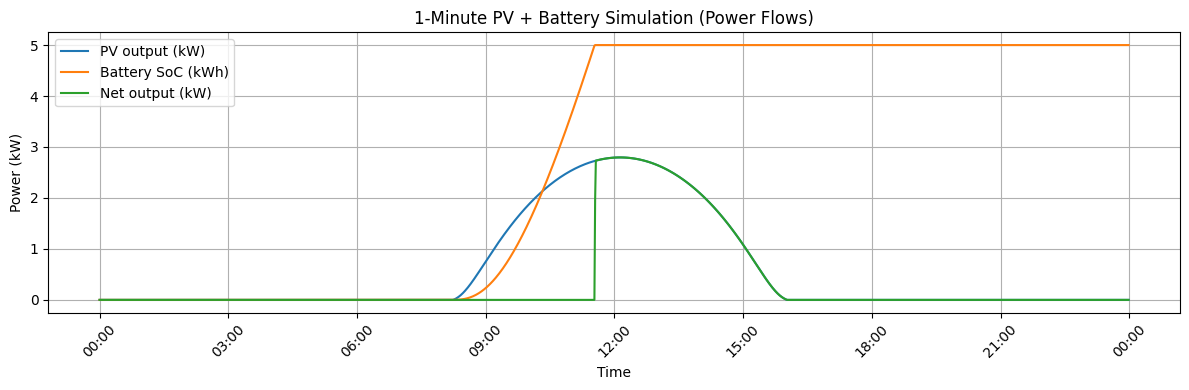

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(results['timestamp'], results['pv_output_kW'], label='PV output (kW)')
plt.plot(results['timestamp'], results['battery_soc_kWh'], label='Battery SoC (kWh)')
plt.plot(results['timestamp'], results['net_output_kW'], label='Net output (kW)')
plt.legend()
plt.title('1-Minute PV + Battery Simulation (Power Flows)')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('PV_load.png', dpi = 300)
plt.show()


In [23]:
# Exporting results to csv
results.to_csv('pv_battery_1min_11jan2025.csv', index=False)

In [24]:
# Max PV output by day
print("11 Jan - Total PV Output:", results['pv_output_kW'].max(), "kW")

11 Jan - Total PV Output: 2.795546768222562 kW


In [25]:
total_energy_kWh = results['pv_output_kW'].sum() * (1/60)
print(f"Total energy output from PV: {total_energy_kWh:.2f} kWh")


Total energy output from PV: 13.78 kWh


In [26]:
# Time when battery first reached full capacity (5 kWh)
first_full = results[results['battery_soc_kWh'] >= 5.0].iloc[0]['timestamp']

print("11 Jan - Battery reached 5 kWh at:", first_full)


11 Jan - Battery reached 5 kWh at: 2025-01-11 11:33:00+00:00


In [27]:
energy_summary = {
    'Total PV Output (kWh)': results['pv_output_kW'].sum() / 60,
    'Total Battery Charged (kWh)': results['battery_charge_kW'].sum() / 60,
    'Total Battery Discharged (kWh)': results['battery_discharge_kW'].sum() / 60,
    'Final Battery SoC (kWh)': results['battery_soc_kWh'].iloc[-1],
    'Total Net Output to Grid (kWh)': results['net_output_kW'].sum() / 60
}

pd.Series(energy_summary).round(3)


Total PV Output (kWh)             13.781
Total Battery Charged (kWh)        5.270
Total Battery Discharged (kWh)     0.000
Final Battery SoC (kWh)            5.000
Total Net Output to Grid (kWh)     8.511
dtype: float64